In [36]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib import cm
from cmcrameri import cm

In [37]:
def running_mean(x, N, mode):
    
    '''
    uses np.convolve to return a running mean.
    X: 1D array or list of values to compute running mean
    N: window size of running mean
    mode: valid, full or same (see https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    for an example of the difference). I would default to 'valid' as it returns 
    an array of the same size passed in
    '''
    #x = np.pad(x, (0, N // 2), mode='constant', constant_values = np.nan)
    return np.convolve(x, np.ones((N,))/N, mode=mode)

In [38]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [215]:
datadir = '/Users/andrew/Documents/Data/Merdith_sub_zones/'
savedir = '/Users/andrew/Documents/Data/Merdith_sub_zones/'

#some densities
perid_density_g_cm3 = 3.3 #g/cm3
perid_density_g_km3 = perid_density_g_cm3 * 100000**3
perid_density_kg_km3 = perid_density_g_km3 * 1e-3
perid_density_kg_km3 = perid_density_g_km3 * 1e-3

In [58]:
with open('%ssubduction_tracks_20210419.pickle' % datadir, 'rb') as f:
    tracks = pickle.load(f)

In [59]:
antigorite_df = pd.read_csv('%sAntigorite_dehydration/atg-out_reaction.csv' % datadir)
df_syracuse = pd.read_csv('%ssyracuse_thermal/Table_2_sub_parameters.csv' % datadir)
df_results = pd.read_csv('%sPT_results_20210205.csv' % datadir)
#sub_length = pd.read_csv('%ssub_length.csv' % datadir)


In [60]:
target_temp = [0, 550]
target_pressure = [1, 6]
target_sub_chron = [0, 5]

In [61]:
pressure_range = np.linspace(0,7,20)
temp_range = np.linspace(100,700,20)
pressure_steps = []
temp_steps = []
variables = []
for ind, (i,j) in enumerate(zip(temp_range, pressure_range)):
    if ind == len(temp_range)-1:
        
        break
    else:
        
        start_pressure = pressure_range[ind]
        final_pressure = pressure_range[ind+1]
        pressure_steps.append(([start_pressure, final_pressure]))

        start_temp = temp_range[ind]
        final_temp = temp_range[ind+1]
        temp_steps.append(([start_temp, final_temp]))
pressure_steps = np.asarray(pressure_steps)
temp_steps = np.asarray(temp_steps)

In [62]:
x, y = np.meshgrid(pressure_steps[:,0], temp_steps[:,0])
perid_reshape = np.reshape(df_results['total_peridotite'].values, np.shape(y))

In [63]:
window= 5
ant_rho_running_mean = running_mean(antigorite_df['P_[kbar]']/10, window, 'valid')
ant_temp_running_mean = running_mean(antigorite_df['T_[C]'], window, 'valid')


/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


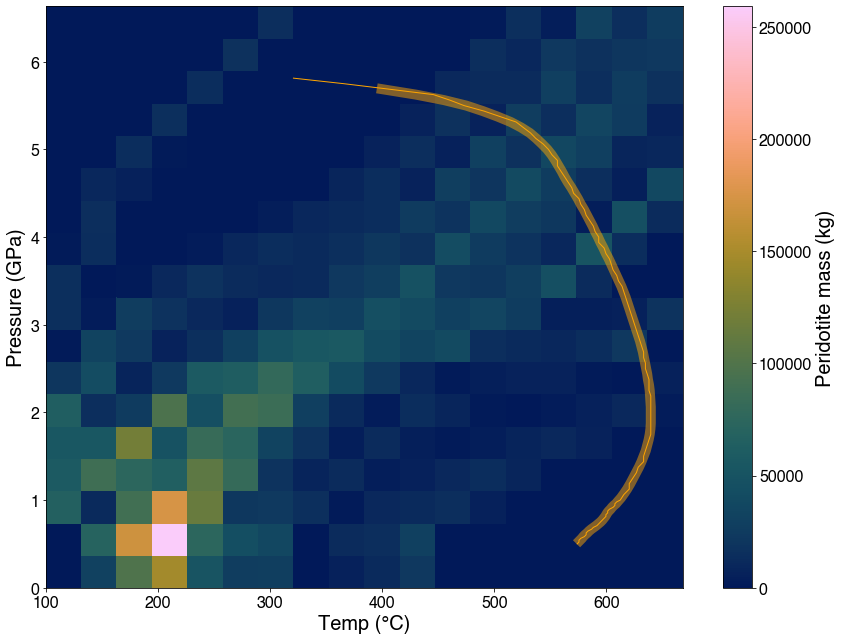

In [64]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=1,
                       figsize=(12,9))


#print ax
c = ax.pcolor(y, x, perid_reshape, zorder=0, cmap=cm.batlow)
ax.set_ylabel('Pressure (GPa)', fontsize=20)
ax.set_xlabel('Temp (°C)', fontsize=20)
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('Peridotite mass (kg)', fontsize=20)
cbar.ax.tick_params(labelsize=16)
#ax.set_ylim(100)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.plot(ant_temp_running_mean, ant_rho_running_mean, c='orange', lw=10, alpha=0.5)
ax.plot(antigorite_df['T_[C]'], antigorite_df['P_[kbar]']/10, c='orange', lw=1)
#plt.gca().invert_yaxis()
#ax.set_xlim(100)
fig.tight_layout()

In [65]:
min_pressure = antigorite_df['P_[kbar]'].min()/10
max_pressure = antigorite_df['P_[kbar]'].max()/10
min_temp = antigorite_df['T_[C]'].min()
max_temp = antigorite_df['T_[C]'].max()

In [216]:
#filter rows beneath ATG line
ant_stability = []
for ind,cross_section in enumerate(tracks):
    #print (ind)
    relative_dfs = []
    for index, row in cross_section.iterrows():
        if row['pressure'] < min_pressure:
            #print(row['pressure'])
            relative_dfs.append(row)
            #print(row['pressure'])
        else:
            target_conditions = [row['pressure'], row['temp']]
            nearest_pressure, nearest_index = find_nearest(antigorite_df['P_[kbar]'].values/10,
                                                           target_conditions[0])

            corresponding_temp = antigorite_df['T_[C]'][nearest_index]
            if row['temp'] < corresponding_temp:
                relative_dfs.append(row)
                
    if len(relative_dfs) != 0:
        ant_stability.append(pd.DataFrame(relative_dfs))
        
        
#save as pickle
with open('%sanitgorite_tracks_20210419.pickle' % savedir, 'wb') as f:
    pickle.dump(ant_stability, f)

In [164]:
#define target temp and pressure for serpentinisation

all_perids = []
dummy_value = 0.6

for ind, track in enumerate(ant_stability):
    tmp_df = ant_stability[ind]
    
    perid_values = tmp_df['peridotite'].values #dummy_value
    
    #because the shallowest sub point has length of 'nan' we have to check
    try:
        perid_volume = (perid_values * tmp_df['slab_section_length'] * tmp_df['sub_length']).sum()
    except:
        #just assume 1 km 'length' of slab for initial
        perid_volume = (1 * perid_values * tmp_df['sub_length']).sum()
        
    all_perids.append(perid_volume)#np.concatenate(perids).ravel())

all_perids = np.asarray(all_perids, dtype=object)


In [172]:
steps = 45
ant_stab_pressure_range = np.linspace(0,max_pressure,steps)
ant_stab_temp_range = np.linspace(0,max_temp,steps)
pressure_steps = []
temp_steps = []
variables = []
for ind, (i,j) in enumerate(zip(ant_stab_temp_range, ant_stab_pressure_range)):
    if ind == len(ant_stab_temp_range)-1:
        
        break
    else:
        
        start_pressure = ant_stab_pressure_range[ind]
        final_pressure = ant_stab_pressure_range[ind+1]
        pressure_steps.append(([start_pressure, final_pressure]))

        start_temp = ant_stab_temp_range[ind]
        final_temp = ant_stab_temp_range[ind+1]
        temp_steps.append(([start_temp, final_temp]))
ant_stab_pressure_steps = np.asarray(pressure_steps)
ant_stab_temp_steps = np.asarray(temp_steps)

In [173]:
#make PT stats
#get stats for matrix

total_peridotite = []
conditions = []
sub_segment_length = []
#define arbitary peridotite value (in km)
dummy_value = 0.3

#loop through our conditions
for ind, T_range in enumerate(temp_steps):
    for ind2, rho_range in enumerate(pressure_steps):

        #define our target conditions
        target_temp = T_range
        target_pressure = rho_range
        conditions.append([T_range, rho_range])
        #print(target_temp, target_pressure)
        
        #arrays to store tmp results
        tmp_perid = []
        tmp_sub_length = []
        #loop through tracks
        for ind3, track in enumerate(ant_stability):
            tmp_df =  track[(track['temp'] > target_temp[0])
                          & (track['temp'] < target_temp[1])
                          & (track['pressure'] > target_pressure[0])
                          & (track['pressure'] < target_pressure[1])]
            if tmp_df.empty is False:
                #print(tmp_df)

                #change to dummy values for comparison
                perid_values = tmp_df['peridotite'].values #dummy_value
                #because the shallowest sub point has length of 'nan' we have to check
                try:
                    perid_volume = (perid_values * tmp_df['slab_section_length'] * tmp_df['sub_length']).sum()
                except:
                    #just assume 1 km 'length' of slab for initial
                    perid_volume = (1 * perid_values * tmp_df['sub_length']).sum()
                tmp_perid.append(perid_volume)
            else:
                continue
        total_peridotite.append(np.sum(tmp_perid))
#conver to array
conditions = np.asarray(conditions)
total_peridotite = np.asarray(total_peridotite)

In [174]:
x, y = np.meshgrid(ant_stab_pressure_steps[:,0], ant_stab_temp_steps[:,0])
perid_reshape = np.reshape(total_peridotite, np.shape(y))

Text(0, 0.5, 'Pressure (GPa)')

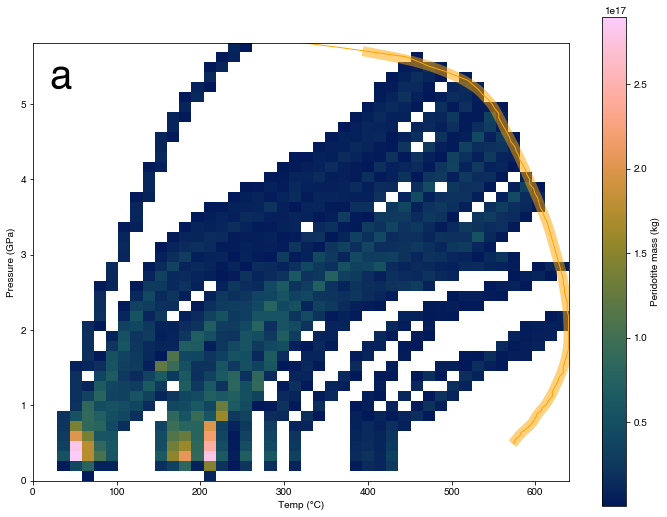

In [200]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=1,
                       figsize=(12,9))
perid_reshape[perid_reshape == 0.0] = np.nan
im = ax.imshow(perid_reshape.T*perid_density_kg_km3, origin='lower', extent=[0, max_temp, 0, max_pressure],aspect=90, cmap=cm.batlow)
ax.set_ylim(0,max_pressure)
ax.set_xlim(0,max_temp)
ax.plot(antigorite_df['T_[C]'], antigorite_df['P_[kbar]']/10, c='orange', lw=1)
ax.plot(ant_temp_running_mean, ant_rho_running_mean, c='orange', lw=10, alpha=0.5)
ax.text(20, 5.2, 'a', fontsize=40)
cbar = plt.colorbar(im)
cbar.set_label('Peridotite mass (kg)')
ax.set_xlabel('Temp (°C)')
ax.set_ylabel('Pressure (GPa)')

In [187]:
#masses below the antigorite stability curve

In [217]:
#1km
#some densities
perid_density_g_cm3 = 3.3 #g/cm3
perid_density_g_km3 = perid_density_g_cm3 * 100000**3
perid_density_kg_km3 = perid_density_g_km3 * 1e-3
water_react = perid_density_kg_km3 * np.nansum(perid_reshape)
H2_kg = water_react * 10e-2
H2_moles = H2_kg/(1.00784*2)
print('perid (km3)', np.nansum(perid_reshape))
print('perid (kg/5 Ma)', water_react)
print('perid (kg/a)', water_react/1000000/5)
print('H2 (kg/5 Ma)', H2_kg)
print('H2 (kg/a)', H2_kg/1000000/5)
print('H2 (moles/5 Ma)', H2_moles)
print('H2 (moles/a)', H2_moles/1000000/5)

perid (km3) 6608290.726767528
perid (kg/5 Ma) 2.180735939833284e+19
perid (kg/a) 4361471879666.569
H2 (kg/5 Ma) 2.1807359398332844e+18
H2 (kg/a) 436147187966.65686
H2 (moles/5 Ma) 1.0818859838036218e+18
H2 (moles/a) 216377196760.72433


In [ ]:
436147187966.65686

In [207]:
np.nanmax(total_peridotite_plot)

2.897408078045596e+17

Text(5.5, 2.5e+17, 'c')

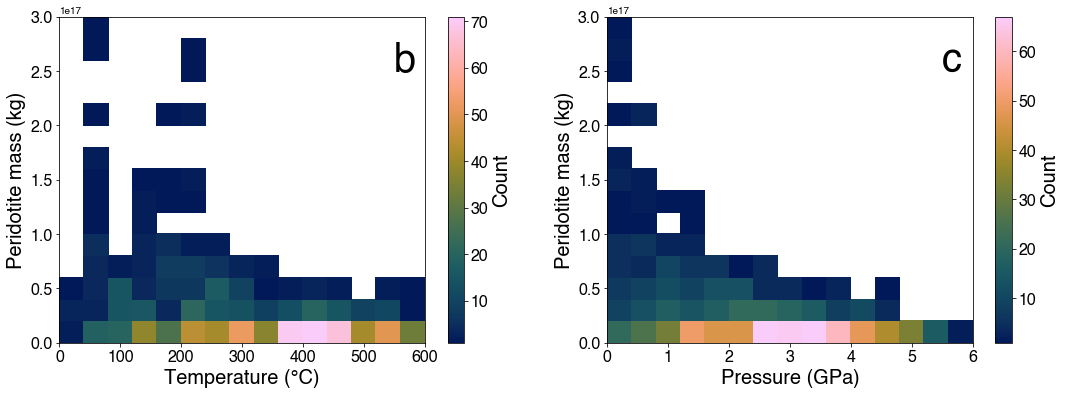

In [213]:
total_peridotite_plot = np.asarray(total_peridotite*perid_density_kg_km3)

fig, (ax1, ax2) = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(18,6))

c1 = ax1.hist2d(conditions[:,0][:,0], total_peridotite_plot, 
                bins=15, range=[[0, 600], [1, 3e17]], cmin = 1, cmap=cm.batlow)
cbar1 = fig.colorbar(c1[3], ax=ax1)
cbar1.set_label('Count', fontsize=20)
cbar1.ax.tick_params(labelsize=16)
ax1.set_ylabel('Peridotite mass (kg)', fontsize=20)
ax1.set_xlabel('Temperature (°C)', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.text(550, 2.5e17,'b',fontsize=40)

c2 = ax2.hist2d(conditions[:,1][:,0], total_peridotite_plot,
                bins=15, range=[[0, 6], [1, 3e17]], cmin = 1, cmap=cm.batlow)
cbar2 = fig.colorbar(c2[3], ax=ax2)
cbar2.set_label('Count', fontsize=20)
cbar2.ax.tick_params(labelsize=16)
ax2.set_ylabel('Peridotite mass (kg)', fontsize=20)
ax2.set_xlabel('Pressure (GPa)', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.text(5.5, 2.5e17,'c',fontsize=40)